## OLS Model

In [1]:
## Laading libraries
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
# 2019 stock data for P&G from Yahoo:
PG = DataReader('PG',  'yahoo', datetime(2019,1,1), datetime(2019,12,31));

# # Avergae of opening and closing:
PG["Average"] = (PG["Open"] + 4*PG["High"] + PG["Close"])/4
PG["Days"] = range(1,PG.shape[0]+1)

# Required Dataset: 
print(PG.shape)
print(PG.head())

(252, 8)
                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2019-01-02  91.389999  89.930000  91.029999  91.279999   9843900.0  88.258690   
2019-01-03  92.500000  90.379997  90.940002  90.639999   9820200.0  87.639870   
2019-01-04  92.489998  90.370003  90.839996  92.489998  10565700.0  89.428635   
2019-01-07  92.500000  91.400002  91.910004  92.120003   9012500.0  89.070892   
2019-01-08  93.089996  91.820000  92.699997  92.459999   9551300.0  89.399635   

               Average  Days  
Date                          
2019-01-02  136.967499     1  
2019-01-03  137.895000     2  
2019-01-04  138.322496     3  
2019-01-07  138.507502     4  
2019-01-08  139.379995     5  


In [3]:
# loading data with Fama French variables
FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\data.csv")

# Filter data for 2019 year
FF["Date"] = pd.to_datetime(FF["Date"])
FF_2019 = FF[(FF["Date"] >= "2019-01-01") & (FF["Date"] <= "2019-12-31")]
FF_2019 = FF_2019.drop(columns = ["Date","High","Low","Open","Close","Volume","Adj Close"])
print(FF_2019.shape)
print(FF_2019.head())

(252, 6)
      Mkt-RF   SMB   HML   RMW   CMA    RF
4779    0.23  0.73  1.15 -0.13  0.26  0.01
4780   -2.45  0.52  1.23 -0.25  0.91  0.01
4781    3.55  0.39 -0.74 -0.09 -0.58  0.01
4782    0.94  0.82 -0.67 -0.70 -0.41  0.01
4783    1.01  0.44 -0.53  0.35 -0.09  0.01


In [4]:
# Final Dataframe for OLS Model:
PG = PG.reset_index()
FF_2019 = FF_2019.reset_index()
df_main = pd.concat([PG,FF_2019], axis =1)
print(df_main.shape)

(252, 16)


In [5]:
df_main = df_main.drop(columns =["index","Date"])
df_main.head()
print(df_main.shape)

(252, 14)


In [6]:
df_main

,High,Low,Open,Close,Volume,Adj Close,Average,Days,Mkt-RF,SMB,HML,RMW,CMA,RF
0,91.389999,89.930000,91.029999,91.279999,9843900.0,88.258690,136.967499,1,0.23,0.73,1.15,-0.13,0.26,0.010
1,92.500000,90.379997,90.940002,90.639999,9820200.0,87.639870,137.895000,2,-2.45,0.52,1.23,-0.25,0.91,0.010
2,92.489998,90.370003,90.839996,92.489998,10565700.0,89.428635,138.322496,3,3.55,0.39,-0.74,-0.09,-0.58,0.010
3,92.500000,91.400002,91.910004,92.120003,9012500.0,89.070892,138.507502,4,0.94,0.82,-0.67,-0.70,-0.41,0.010
4,93.089996,91.820000,92.699997,92.459999,9551300.0,89.399635,139.379995,5,1.01,0.44,-0.53,0.35,-0.09,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,125.309998,124.580002,124.790001,125.220001,2022100.0,124.480438,187.812498,248,0.01,0.36,-0.07,-0.28,0.02,0.007
248,125.750000,124.870003,125.099998,125.220001,4760400.0,124.480438,188.330000,249,0.49,-0.56,0.00,0.23,-0.19,0.007
249,126.300003,125.389999,125.559998,126.089996,5192000.0,125.345299,189.212502,250,-0.09,-0.54,-0.07,0.24,0.16,0.007
250,125.980003,124.139999,125.760002,124.470001,3884300.0,123.734871,188.537504,251,-0.57,0.27,0.58,0.15,0.45,0.007


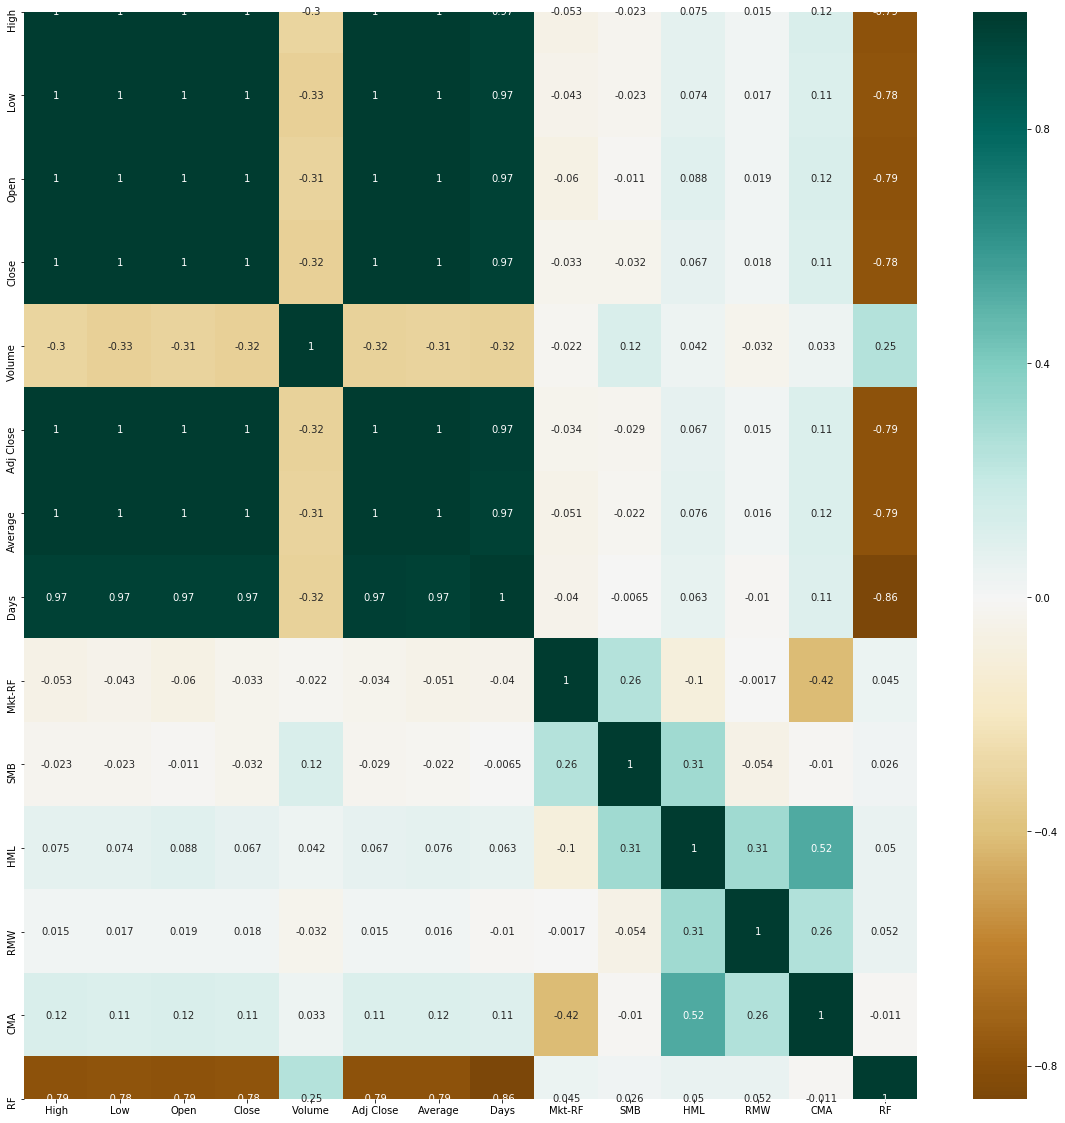

In [7]:
#Visualisation:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_main.corr(), center=0, cmap="BrBG", annot=True)

In [8]:
# Variables for OLS model: 
# RF, CMA, RMV, HML, SMB, mkt-RF, Close - Independent Variable
# Open - Dependent Varibale

x_t = np.array(df_main[["RF","CMA","RMW","HML","SMB","Mkt-RF","Average", "Days"]].shift(periods=-1).dropna())
y_t = np.array(df_main[["Open"]].shift(periods=1).dropna())

In [9]:
x_t.shape

(251, 8)

In [10]:
y_t.shape

(251, 1)

In [11]:
b_t = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_t.T,x_t)),x_t.T),y_t) 

In [12]:
b_t.tolist()

[[84.65393485185359],
 [-0.3355354281536309],
 [0.05617449733306179],
 [-0.026389244282980506],
 [0.4531444871487089],
 [-0.35249089857846716],
 [0.655302763899207],
 [0.004497347506128228]]